## A simple model for demand and supply of geolocalized services in a city

### Load libraries and classes

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

import os
import sys
nb_dir = os.path.dirname(os.getcwd()) ## TODO: find way to put this into some global settings
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from references import common_cfg, istat_kpi, city_settings

In [2]:
from src.models.city_items import AgeGroup, ServiceArea, ServiceType, SummaryNorm # enum classes for the model
from src.models.core import ServiceUnit, ServiceValues, ServiceEvaluator, \
    MappedPositionsFrame, DemandFrame, KPICalculator
from src.models.factories import UnitFactory
from src.models.process_tools import GridMaker, ValuesPlotter, JSONWriter

In [3]:
selected_city = 'Milano'

### Load service data: locations, scales, other info for city

In [4]:
loaders=UnitFactory.make_loaders_for_city(city_settings.get_city_config(selected_city))
loaders

{'Biblioteche': <src.models.factories.LibraryFactory at 0x7f3670df6390>,
 'Farmacie': <src.models.factories.PharmacyFactory at 0x7f3635067e80>,
 'Fermate TPL': <src.models.factories.TransportStopFactory at 0x7f36350679b0>,
 'Scuole': <src.models.factories.SchoolFactory at 0x7f3670df6240>}

In [5]:
# Initialise with a default lengthscale of 0.5 km
school_units = loaders['Scuole'].load(mean_radius=0.5)

# Initialise with a default lengthscale of 0.6 km
pharmacy_units = loaders['Farmacie'].load(mean_radius=0.5)

# Initialise with a default lengthscale of 0.3 km
## awful hack to quickly clean tpl file #FIXME
loaders['Fermate TPL']._raw_data = loaders['Fermate TPL']._raw_data[
    loaders['Fermate TPL']._raw_data['route_type'].isin([0,1,3])].reset_index()

tpl_units = loaders['Fermate TPL'].load(mean_radius=0.3)

# Initialise with a default lengthscale of 0.5 km
library_units = loaders['Biblioteche'].load(mean_radius=0.5)

Location data found
ServiceType.School -- dropping 1 units outside city.
Location data found
ServiceType.Pharmacy -- dropping 71 units outside city.
Location data found
Location data found
ServiceType.Library -- dropping 95 units outside city.


### Demand import from Censimento Popolazione e Abitazioni (CPA) 2011

In [6]:
demand_data = DemandFrame.create_from_istat_cpa(selected_city)

b_demo = False
if b_demo:
    # demo mode, use a portion of the data
    demand_test = DemandFrame(demand_data.sample(50, random_state=80).copy(), False)
    test_units = school_units[::50] + pharmacy_units[::30] + tpl_units[::30] 
    calculator = KPICalculator(demand_test, test_units, selected_city)
else:
    calculator = KPICalculator(
        demand_data, school_units + pharmacy_units + tpl_units + library_units, 
        selected_city)
    calculator = KPICalculator(
        demand_data, school_units + library_units, selected_city)

### Evaluate the services offer at the demand points and average over neighbourhood

In [14]:
calculator.evaluator.attendance_tree[ServiceType.School]

array([[2.33963705e+02, 5.00000000e-01],
       [2.62814896e+02, 5.00000000e-01],
       [3.25617805e+02, 5.00000000e-01],
       [2.28964185e+02, 5.00000000e-01],
       [3.23240013e+02, 5.00000000e-01],
       [2.36340015e+02, 5.00000000e-01],
       [3.19180464e+02, 5.00000000e-01],
       [3.29134029e+02, 5.00000000e-01],
       [1.73276858e+02, 5.00000000e-01],
       [2.76140426e+02, 5.00000000e-01],
       [2.08347965e+02, 5.00000000e-01],
       [2.90443238e+02, 5.00000000e-01],
       [2.60852622e+02, 5.00000000e-01],
       [2.14758383e+02, 5.00000000e-01],
       [2.81933719e+02, 5.00000000e-01],
       [2.57150162e+02, 5.00000000e-01],
       [2.17250319e+02, 5.00000000e-01],
       [1.88829075e+02, 5.00000000e-01],
       [2.60237199e+02, 5.00000000e-01],
       [3.13416941e+02, 5.00000000e-01],
       [2.98957401e+02, 5.00000000e-01],
       [2.46881892e+02, 5.00000000e-01],
       [1.54970160e+02, 5.00000000e-01],
       [2.55885577e+02, 5.00000000e-01],
       [2.764890

In [12]:
# print current value of kernel cutoff
print('Ignoring interactions below %s \n' % common_cfg.kernel_value_cutoff)

# compute and plot demand/supply interaction for localized services 
calculator.evaluate_services_at_demand(b_evaluate_attendance=True, clip_level=1.01)  # this might take a while.

calculator.compute_kpi_for_localized_services()

for _,loader in loaders.items():
    loader.save_units_with_attendance_to_geojson(calculator.evaluator.units)

Ignoring interactions below 0.0001 

Found existing interactions, using them
ServiceType.Library: AgeGroup.ChildPrimary -- unassigned: 1359 | Total: 53328
ServiceType.Library: AgeGroup.Young -- unassigned: 1129 | Total: 50239
ServiceType.Library: AgeGroup.Senior -- unassigned: 6675 | Total: 306124
ServiceType.Library: AgeGroup.ChildHigh -- unassigned: 1142 | Total: 47288
ServiceType.Library: AgeGroup.Over50 -- unassigned: 4805 | Total: 232220
ServiceType.Library: AgeGroup.Over65 -- unassigned: 3914 | Total: 151541
ServiceType.Library: AgeGroup.Junior -- unassigned: 2454 | Total: 136507
ServiceType.Library: AgeGroup.Over74 -- unassigned: 3457 | Total: 158280
ServiceType.Library: AgeGroup.ChildMid -- unassigned: 1380 | Total: 48987
ServiceType.School: AgeGroup.ChildPrimary -- unassigned: 5 | Total: 53328
ServiceType.School: AgeGroup.ChildMid -- unassigned: 2 | Total: 48987


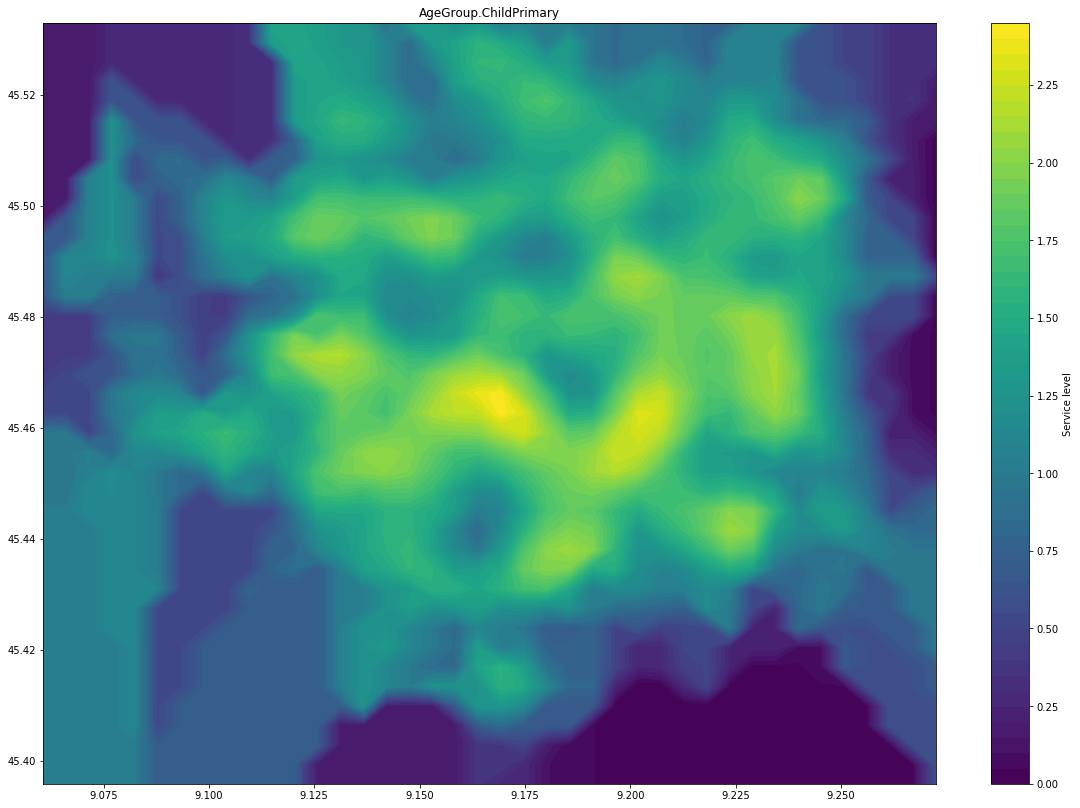

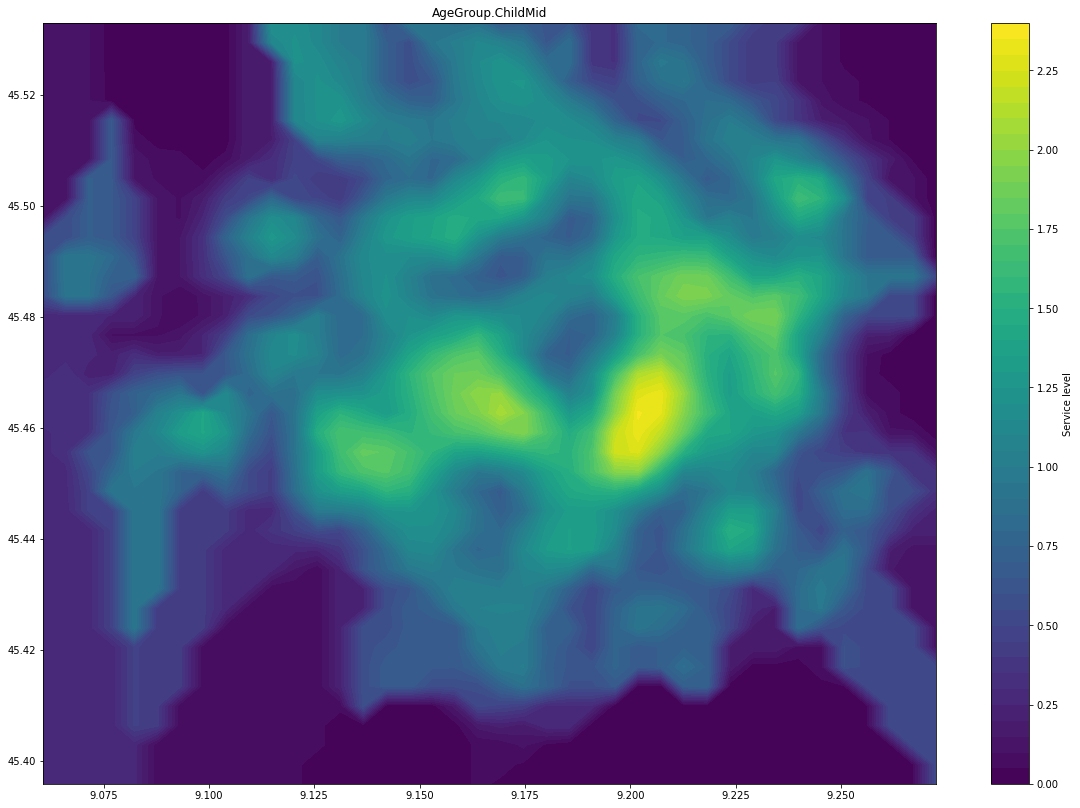

In [13]:
ptt = ValuesPlotter(calculator.service_values)
ptt.plot_service_levels(ServiceType.School)
#ptt.plot_service_levels(ServiceType.TransportStop)


0.0 62675.84633144633


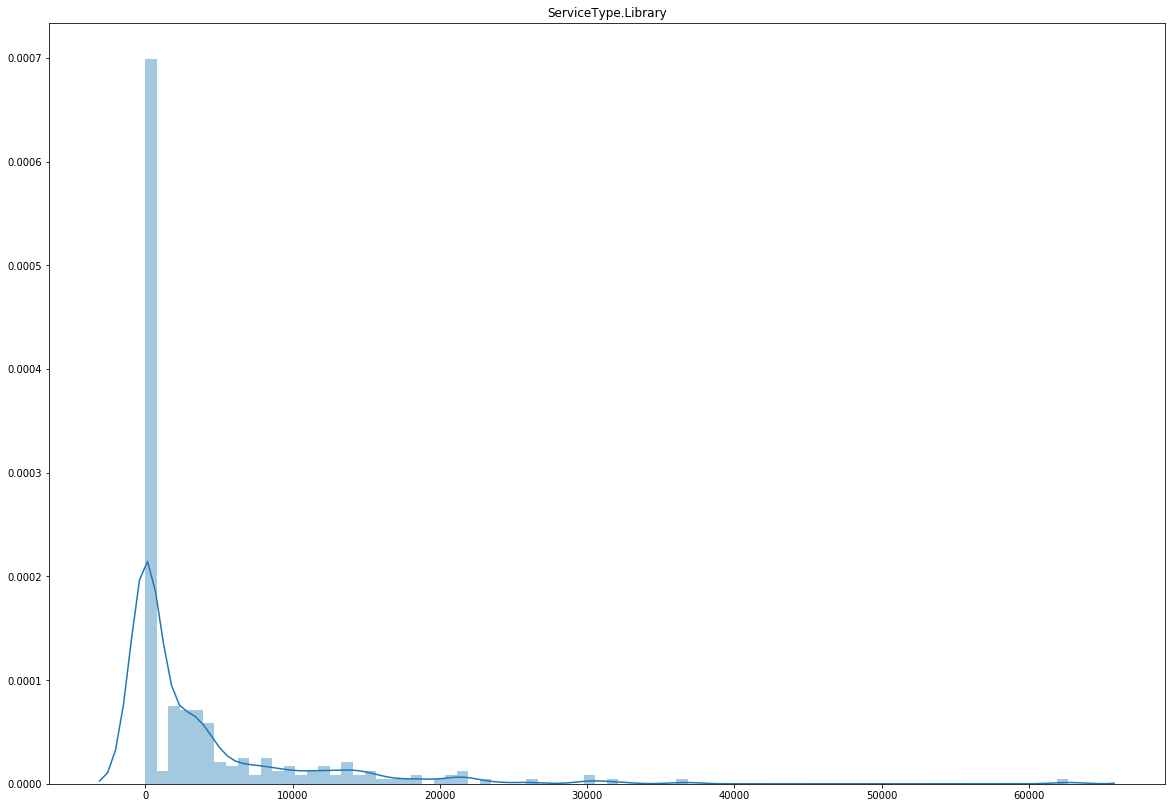

43.26910393664102 942.9927879163129


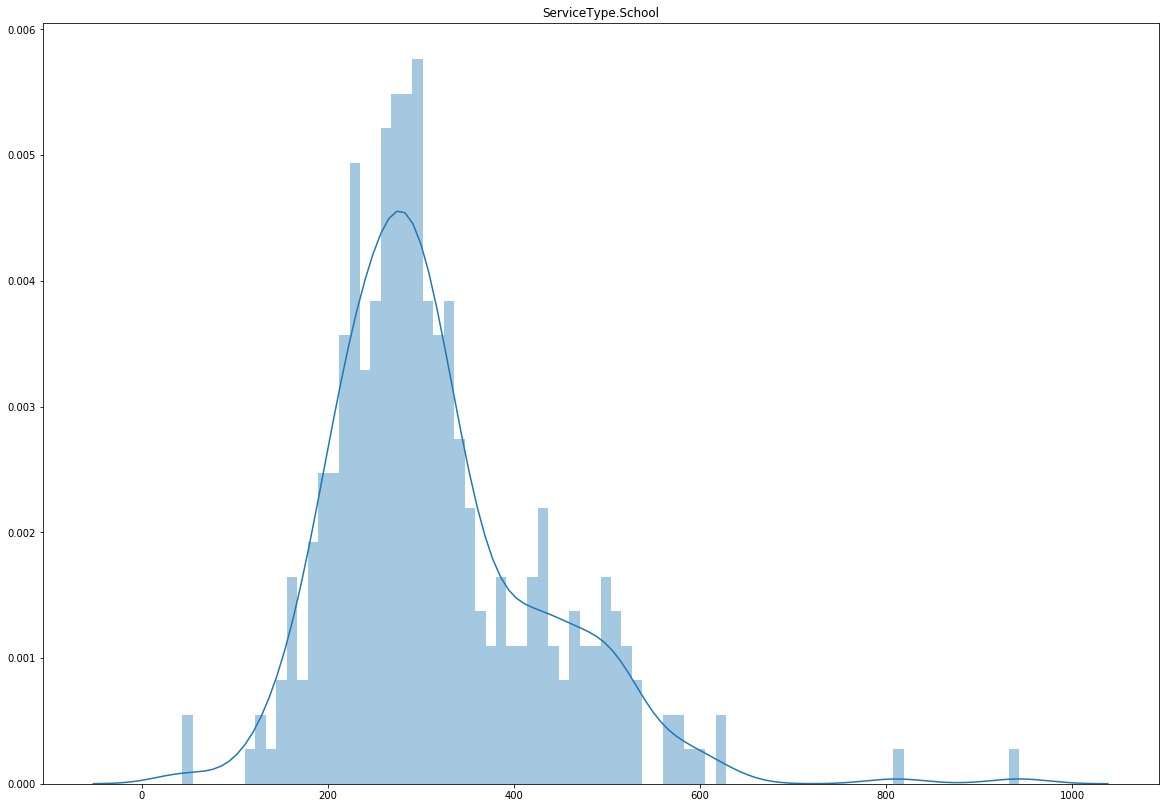

In [9]:
for service_type, units in calculator.evaluator.units_tree.items():
    values = [u.attendance for u in units]
    print(min(values), max(values))
    sns.distplot(values, 80)
    plt.title(service_type)
    plt.show()

### Append Istat KPI and export averaged values by Neighbourhood-Service-AgeGroup to JSON

In [10]:
# compute istat kpi as well
calculator.compute_kpi_for_istat_values()

# write KPI to json outputb
json_maker = JSONWriter(calculator)
json_maker.write_all_files_to_default_path()

In [11]:
b_save_pickle = False
import pickle
import time
filename = './pickles/'+ selected_city + '_%i.pickle' % int(time.time())
if b_save_pickle:
    with open(filename, 'wb') as f:
        pickle.dump(calculator, f)